Examine sensitivity of current best model (Gear-Specific, Multi-Window 
Logistic Model with is-daylight) with respect to degredation of the AIS
data. 

We train as normal, then progessively randomly dropout more and more of
the training data and see how that effects the resulting reported
accuracies.

In [1]:
%matplotlib inline
from __future__ import print_function, division
import sys
sys.path.append('..')
from vessel_scoring import data, utils
from vessel_scoring.models import train_model_on_data
from vessel_scoring.evaluate_model import evaluate_model, compare_models
from IPython.core.display import display, HTML, Markdown
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
from vessel_scoring.logistic_model import LogisticModel

def make_model(seed=4321):
    return LogisticModel(colspec=dict(
        windows=[1800, 3600, 10800, 21600, 43200, 86400],
        measures=['measure_daylight', 'measure_speed']), order=6, random_state=seed)


In [3]:
def load_data(suffix='', seed=4321):
    # Data supplied by Kristina
    _, train_lline,  valid_lline, test_lline = data.load_dataset_by_vessel(
            '../datasets/kristina_longliner.measures{}.npz'.format(suffix), seed)
    _, train_trawl,  valid_trawl, test_trawl = data.load_dataset_by_vessel(
            '../datasets/kristina_trawl.measures{}.npz'.format(suffix), seed)
    _, train_pseine, valid_pseine, test_pseine = data.load_dataset_by_vessel(
            '../datasets/kristina_ps.measures{}.npz'.format(suffix), seed)

    # Slow transits (used to train models to avoid classifying slow transits as fishing)
    TRANSIT_WEIGHT = 10
    x_tran, xtrain_tran, xcross_tran, xtest_tran = data.load_dataset_by_vessel(
                        '../datasets/slow-transits.measures{}.npz'.format(suffix), even_split=False, seed=seed)
    xtrain_tran = utils.clone_subset(xtrain_tran, test_lline.dtype)
    xcross_tran = utils.clone_subset(xcross_tran, test_lline.dtype)
    xtest_tran = utils.clone_subset(xtest_tran, test_lline.dtype)
    train_tran = np.concatenate([xtrain_tran, xcross_tran] * TRANSIT_WEIGHT)

    train = {'longliner': np.concatenate([train_lline, valid_lline, train_tran]), 
                'trawler': np.concatenate([train_trawl, valid_trawl, train_tran]),
                'purse_seine': np.concatenate([train_pseine, valid_pseine, train_tran])}
    
    test = {'longliner': test_lline, 
            'trawler': test_trawl, 
            'purse_seine': test_pseine}
    
    return train, test

To create the features:

```
python scripts/add_all_features.py --keep 0.5
python scripts/add_all_features.py --keep 0.2
python scripts/add_all_features.py --keep 0.1
python scripts/add_all_features.py --keep 0.05
python scripts/add_all_features.py --keep 0.02
python scripts/add_all_features.py --keep 0.01
python scripts/add_all_features.py --keep 0.002
python scripts/add_all_features.py --keep 0.005
```

In [4]:
keep_probs = [1, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002]

train_data, test_data = load_data()

drop_test = {1: test_data}
for kp in keep_probs[1:]:
    suffix = '-{}'.format(str(kp).replace('.', ''))
    drop_test[kp] = load_data(suffix=suffix)[1]

predictions = {}

for gear in ['purse_seine', 'trawler', 'longliner']:
    mdl = make_model()
    train_model_on_data(mdl, train_data[gear])
    
    display(HTML("<h2>{}</h2>".format(gear.replace('_', ' ').title())))
                
    predictions[gear] = []
    for kp in keep_probs:  

        td = drop_test[kp][gear]
            
        raw = mdl.predict_proba(td)[:,1]
        predictions[gear].append((kp, td, raw, (raw > 0.5), td['classification'] > 0.5))

    lines = ["|Keep Prob|Recall|Precision|F1-Score|ROC-AUC|",
             "|---------|------|---------|--------|-------|"]
    for name, td, raw, pred, actual in predictions[gear]:
        fpr, tpr, thresholds = metrics.roc_curve(actual, raw)
        auc = metrics.auc(fpr, tpr)
        lines.append("|{}|{:.2f}|{:.2f}|{:.2f}|{:.2f}|".format(name, 
                                            metrics.recall_score(actual, pred),
                                            metrics.precision_score(actual, pred), 
                                            metrics.f1_score(actual, pred),
                                            auc))

    display(Markdown('\n'.join(lines)))    
    display(HTML("<hr/>"))

Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all

../vessel_scoring/data.py:89: UserWarning: Warning, inufficient items to sample, returning 4430
  warnings.warn("Warning, inufficient items to sample, returning {}".format(len(x)))
../vessel_scoring/data.py:89: UserWarning: Warning, inufficient items to sample, returning 2084
  warnings.warn("Warning, inufficient items to sample, returning {}".format(len(x)))
../vessel_scoring/data.py:89: UserWarning: Warning, inufficient items to sample, returning 2244
  warnings.warn("Warning, inufficient items to sample, returning {}".format(len(x)))



Warning, insufficient items to sample, returning all

../vessel_scoring/data.py:89: UserWarning: Warning, inufficient items to sample, returning 1084
  warnings.warn("Warning, inufficient items to sample, returning {}".format(len(x)))
../vessel_scoring/data.py:89: UserWarning: Warning, inufficient items to sample, returning 922
  warnings.warn("Warning, inufficient items to sample, returning {}".format(len(x)))
../vessel_scoring/data.py:89: UserWarning: Warning, inufficient items to sample, returning 453
  warnings.warn("Warning, inufficient items to sample, returning {}".format(len(x)))
../vessel_scoring/data.py:65: UserWarning: inufficient items to sample, returning fewer
  warnings.warn("inufficient items to sample, returning fewer")



Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all

../vessel_scoring/data.py:89: UserWarning: Warning, inufficient items to sample, returning 467
  warnings.warn("Warning, inufficient items to sample, returning {}".format(len(x)))
../vessel_scoring/data.py:89: UserWarning: Warning, inufficient items to sample, returning 225
  warnings.warn("Warning, inufficient items to sample, returning {}".format(len(x)))
../vessel_scoring/data.py:89: UserWarning: Warning, inufficient items to sample, returning 81
  warnings.warn("Warning, inufficient items to sample, returning {}".format(len(x)))



Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all

../vessel_scoring/data.py:89: UserWarning: Warning, inufficient items to sample, returning 37
  warnings.warn("Warning, inufficient items to sample, returning {}".format(len(x)))
../vessel_scoring/data.py:89: UserWarning: Warning, inufficient items to sample, returning 24
  warnings.warn("Warning, inufficient items to sample, returning {}".format(len(x)))



Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all

../vessel_scoring/data.py:89: UserWarning: Warning, inufficient items to sample, returning 578
  warnings.warn("Warning, inufficient items to sample, returning {}".format(len(x)))
../vessel_scoring/data.py:89: UserWarning: Warning, inufficient items to sample, returning 919
  warnings.warn("Warning, inufficient items to sample, returning {}".format(len(x)))
../vessel_scoring/data.py:89: UserWarning: Warning, inufficient items to sample, returning 12
  warnings.warn("Warning, inufficient items to sample, returning {}".format(len(x)))



Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all


../vessel_scoring/data.py:89: UserWarning: Warning, inufficient items to sample, returning 371
  warnings.warn("Warning, inufficient items to sample, returning {}".format(len(x)))
../vessel_scoring/data.py:89: UserWarning: Warning, inufficient items to sample, returning 6
  warnings.warn("Warning, inufficient items to sample, returning {}".format(len(x)))


|Keep Prob|Recall|Precision|F1-Score|ROC-AUC|
|---------|------|---------|--------|-------|
|1|0.81|0.26|0.39|0.94|
|0.5|0.67|0.24|0.35|0.89|
|0.2|0.61|0.21|0.31|0.89|
|0.1|0.52|0.24|0.33|0.84|
|0.05|0.50|0.17|0.26|0.89|
|0.02|0.23|0.14|0.17|0.80|
|0.01|0.20|0.14|0.16|0.85|
|0.005|0.21|0.20|0.21|0.89|
|0.002|0.00|0.00|0.00|0.94|

|Keep Prob|Recall|Precision|F1-Score|ROC-AUC|
|---------|------|---------|--------|-------|
|1|0.87|0.94|0.90|0.95|
|0.5|0.81|0.93|0.87|0.94|
|0.2|0.81|0.93|0.87|0.94|
|0.1|0.73|0.95|0.83|0.93|
|0.05|0.67|0.97|0.79|0.92|
|0.02|0.50|0.96|0.66|0.90|
|0.01|0.36|0.94|0.52|0.87|
|0.005|0.23|0.95|0.37|0.88|
|0.002|0.08|0.89|0.15|0.89|

|Keep Prob|Recall|Precision|F1-Score|ROC-AUC|
|---------|------|---------|--------|-------|
|1|0.90|0.94|0.92|0.95|
|0.5|0.88|0.96|0.92|0.94|
|0.2|0.87|0.96|0.92|0.94|
|0.1|0.84|0.95|0.89|0.94|
|0.05|0.80|0.97|0.88|0.94|
|0.02|0.63|0.96|0.76|0.90|
|0.01|0.48|0.98|0.65|0.88|
|0.005|0.33|0.96|0.49|0.82|
|0.002|0.12|0.96|0.21|0.83|

The loss of recall of recall / precission as AIS is dropped out is surprisingly low. 
Precision / recall appears to be only modestly effected when dropping out 80% of the
original AIS signal, with the exception of purse seiners, where 50% of the signal can
be dropped with only modest reductions of recall / precision.

In [5]:
def _fishing_hours_per_mmsi(data, preds):
    # assumes single vessel (mmmsi)
    indices = np.argsort(data['timestamp'])
    data = data[indices]
    preds = preds[indices]
    thresholded = (preds > 0.5)
    dt = (data['timestamp'][1:] - data['timestamp'][:-1]) / (60 * 60)
    dt = np.minimum(dt, 12) # no gaps over 12 hours
    avg_pred = 0.5 * (preds[1:] + preds[:-1])
    avg_thresh = 0.5 * (thresholded[1:] + thresholded[:-1])
    avg_nominal = 0.5 * (data['classification'][1:] + data['classification'][:-1])
    return (avg_pred * dt).sum(), (avg_thresh * dt).sum(), (avg_nominal * dt).sum()

def fishing_hours(data, preds):
    mmsi = set(data['mmsi'])
    pred_hours = thresh_hours = nominal_hours = 0
    for m in mmsi:
        mask = (data['mmsi'] == m)
        p_hours, t_hours, n_hours = _fishing_hours_per_mmsi(data[mask], preds[mask])
        pred_hours += p_hours
        thresh_hours += t_hours
        nominal_hours += n_hours
    return pred_hours, thresh_hours, nominal_hours
    
    
predicted_fishing_hours = {}
threshold_fishing_hours = {}
nominal_fishing_hours = {}
    
for gear in ['purse_seine', 'trawler', 'longliner']:
    
    predicted_fishing_hours[gear] = []
    threshold_fishing_hours[gear] = []
    nominal_fishing_hours[gear] = []
    
    display(HTML("<h2>{}</h2>".format(gear.replace('_', ' ').title())))

    lines = ["|Keep Prob|Predicted|Threshold|Nominal|",
             "|---------|---------|---------|-------|"]
    
    for name, td, raw, pred, actual in predictions[gear]:
        predicted, threshold, nominal = fishing_hours(td, raw)
        predicted_fishing_hours[gear].append(predicted)
        threshold_fishing_hours[gear].append(threshold)        
        nominal_fishing_hours[gear].append(nominal)
        lines.append("|{}|{:.2f}|{:.2f}|{:.2f}|".format(name, 
                                                 predicted,
                                                 threshold,
                                                 nominal))
    display(Markdown('\n'.join(lines)))    
    display(HTML("<hr/>"))
    
    

|Keep Prob|Predicted|Threshold|Nominal|
|---------|---------|---------|-------|
|1|1512.36|1142.27|373.63|
|0.5|1488.71|1037.76|433.86|
|0.2|1315.15|860.24|287.81|
|0.1|1267.22|840.48|419.79|
|0.05|998.81|719.34|269.89|
|0.02|792.04|540.76|340.79|
|0.01|571.61|331.72|265.68|
|0.005|213.71|120.44|139.98|
|0.002|52.68|8.17|60.00|

|Keep Prob|Predicted|Threshold|Nominal|
|---------|---------|---------|-------|
|1|4861.90|3166.53|5742.73|
|0.5|4636.80|3139.62|5793.99|
|0.2|4587.38|3119.89|5932.02|
|0.1|4042.30|2849.20|5839.84|
|0.05|3505.37|2449.78|5710.36|
|0.02|2485.84|1876.08|5487.99|
|0.01|1763.98|1444.26|5569.29|
|0.005|1015.83|937.77|5209.30|
|0.002|197.05|136.29|2228.94|

|Keep Prob|Predicted|Threshold|Nominal|
|---------|---------|---------|-------|
|1|5305.60|3354.15|6295.45|
|0.5|5368.05|3353.30|6421.54|
|0.2|5133.51|3268.49|6200.91|
|0.1|4998.18|3192.09|6218.56|
|0.05|4627.15|3011.64|6370.53|
|0.02|3495.47|2479.37|6221.19|
|0.01|2616.38|1989.40|6613.87|
|0.005|1354.91|1166.13|5064.04|
|0.002|283.13|260.86|2485.96|

Compare the fishing hours calculated based on predictions with those based on hand 
labelled data. Fishing hours based on prediction are calculated in two ways. 
One by summing up the fishing scores and the other by thresholding the fishing 
scores at 0.5. In both cases, the scores are weighted by the gaps between points,
capped at 12 hours. See functions above for details.

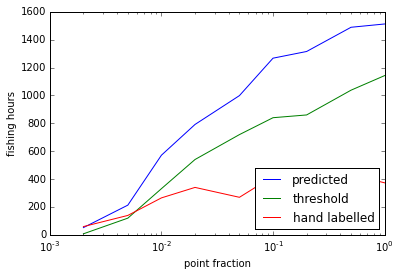

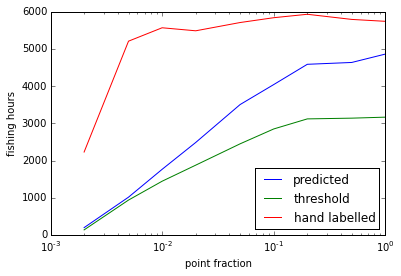

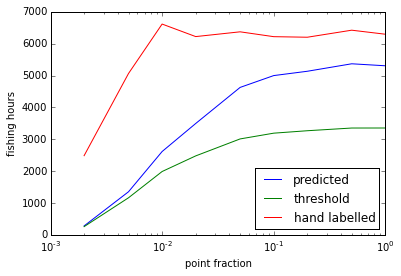

In [6]:
for gear in ['purse_seine', 'trawler', 'longliner']:
    
    
    display(HTML("<h2>{}</h2>".format(gear.replace('_', ' ').title())))

    plt.plot(keep_probs, predicted_fishing_hours[gear], label="predicted")   
    plt.plot(keep_probs, threshold_fishing_hours[gear], label="threshold")   
    plt.plot(keep_probs, nominal_fishing_hours[gear], label="hand labelled")
    plt.xscale('log')
    plt.xlabel('point fraction')
    plt.ylabel('fishing hours')
    plt.legend(loc=4)
    plt.show()
    display(HTML("<hr/>"))

correlation: 0.117689379006


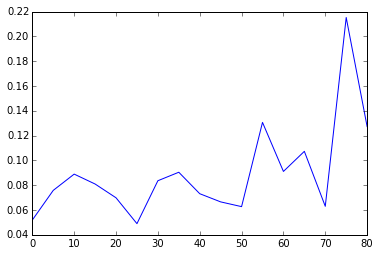

correlation: -0.249910374753


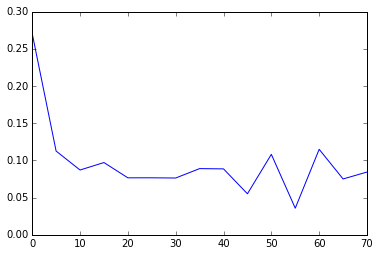

correlation: -0.37721607678


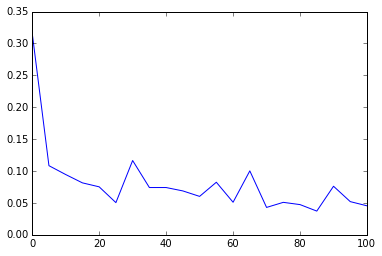

In [7]:
for gear in ['purse_seine', 'trawler', 'longliner']:

    display(HTML("<h2>{}</h2>".format(gear.replace('_', ' ').title())))

    err_chunks = []
    count_chunks = []
    for name, td, raw, pred, actual in predictions[gear]:
        err_chunks.append(raw - td['classification'])
        count_chunks.append(td['measure_count_10800'])
    errs = np.concatenate(err_chunks)
    counts = np.concatenate(count_chunks)

    print("correlation:", np.corrcoef(np.log(counts), abs(errs))[1,0])
    
    bin_starts = []
    bins = []
    for i in range(20):
        start = i * 5
        bin_starts.append(start)
        stop = (i + 1) * 5
        mask = (counts >= start) & (counts < stop)
        bins.append((errs[mask]**2).mean())
        if mask.sum() < 20:
            break
    mask = (counts >= stop)
    bins.append((errs[mask]**2).mean())
    bin_starts.append(stop)


    plt.plot(bin_starts, bins)
    plt.show()